In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import time
from astropy.io import fits
import pandas as pd 
import pyarrow.parquet as parquet
import fast_histogram as fh


In [ ]:
# DBSCAN would be ideal but basically it's way too slow 

In [8]:
def dosemap_ranges(radius):
    slop = 400 - radius
    return [slop, 3200 - slop], [slop, 3200 - slop]

In [12]:
def centile_clip(image, centiles=(0, 90)):
    """
    simple clipping function that clips values above and below a given
    percentile range
    """
    import numpy as np
    finite = np.ma.masked_invalid(image)
    bounds = np.percentile(finite[~finite.mask].data, centiles)
    result = np.ma.clip(finite, *bounds)

    if isinstance(image, np.ma.MaskedArray):
        return result

    return result.data

In [3]:
nf = parquet.read_table("/home/bekah/gPhoton2/test_data/e23456/e23456-nd-b00.parquet").to_pandas()
nf = nf[(nf['row']*4 >= -200) & (nf['row']*4 <= 3400) & (nf['col']*4 >= -200) & (nf['col']*4 <= 3400)]
nf['col_expand'] = nf['col']*(16/3)+200*(4/3)
nf['row_expand'] = nf['row']*(16/3)+200*(4/3)
points = nf[['col_expand', 'row_expand']].values


In [33]:
start_time = time.time()

hist = fh.histogram2d(
        nf['col']*4, nf['row']*4, bins=4800, range=dosemap_ranges(600)
    ).astype('float32')

end_time = time.time()

duration = end_time - start_time
print(f"hist took {duration:.4f} seconds")


hist took 1.0826 seconds


In [31]:
x,y = np.where(hist>250)

In [18]:
np.max(hist)

1846.0

In [19]:
np.std(hist)

4.7572007

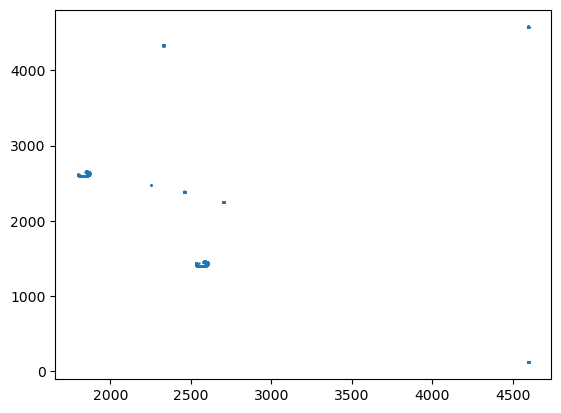

In [32]:
plt.scatter(x,y, s=.5)

In [27]:
x

array([2459, 2459, 2459, 2460, 2460, 2460, 2460, 2460, 2461, 2461, 2461,
       2461, 2701, 2701, 2701, 2702, 2702, 2702, 2703, 2703, 4593, 4594])

In [28]:
y

array([2385, 2386, 2387, 2384, 2385, 2386, 2387, 2388, 2385, 2386, 2387,
       2388, 2247, 2248, 2249, 2247, 2248, 2249, 2248, 2249,  119,  119])

In [55]:
above_30_x, above_30_y = np.where(hist<2)
below_2 = hist<2

In [56]:
points = np.vstack((above_30_x, above_30_y)).T

print(points.shape) 

(14419033, 2)


In [62]:
eps = 1  # maximum distance between two points to be considered in the same neighborhood
min_samples = 8  # minimum number of points to form a dense region (cluster)

# Time the DBSCAN clustering process
start_time = time.time()
db = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
end_time = time.time()


In [63]:
print(end_time-start_time)

94.63494849205017


In [64]:
labels = db.labels_

# Check the first few labels
print(labels[:10])

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [65]:
df = pd.DataFrame({'x': above_30_x, 'y': above_30_y})
df['label'] = labels


In [ ]:
plt.scatter(df['x'],df['y'],c=df['label'],s=.25)